In [ ]:
!/usr/bin/python3 -m pip install -U -r requirements.txt

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors
from collections import OrderedDict
API_KEY = ""

## API request parameters

In [303]:
api_service_name = "youtube"
api_version = "v3"

youtube = googleapiclient.discovery.build(api_service_name, api_version, developerKey=API_KEY)

## Function to get most popular videos in Spain

In [304]:
def pop_vids_spain():

    request = youtube.videos().list(
        part="snippet,statistics",
        chart="mostPopular",
        regionCode="ES",
        maxResults=50
    )
    response = request.execute()

    data = response["items"]

    next_page_token = response.get("nextPageToken")
    more_pages = True

    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.videos().list(
                part="snippet,statistics",
                chart="mostPopular",
                regionCode="ES",
                maxResults = 50,
                pageToken = next_page_token
            )
            response = request.execute()
            data = data + response["items"]
            next_page_token = response.get("nextPageToken")
            
        all_stats = []
        for d in data:
            vid_stats = dict(title = d["snippet"]["title"],
                             likes = d["statistics"].get("likeCount"),
                             views = d["statistics"]["viewCount"],
                             comments = d["statistics"].get("commentCount"),
                             channel_ids = d["snippet"]["channelId"],
                             video_channel_title = d["snippet"]["channelTitle"],
                             category_id = d["snippet"]["categoryId"])
            all_stats.append(vid_stats)

    return all_stats

## Function to get channel data

In [305]:
def get_channel_info(channel_id):
    
    data = []

    for i in range(0,len(channel_id),50):
        request = youtube.channels().list(
            part="snippet,statistics",
            id=",".join(channel_id[i:i+50])
        )
        response = request.execute()
        data = data + response["items"]
        
    all_stats = []
    for d in data:
        channel_stats = dict(channel_title = d["snippet"]["title"],
                             channel_views = d["statistics"]["viewCount"],
                             subscribers = d["statistics"].get("subscriberCount"),
                             country = d["snippet"].get("country"))
        all_stats.append(channel_stats)

    return all_stats

## Function to get categories

In [328]:
def get_categories():
    
    data = []
    ids = []

    
    request = youtube.videoCategories().list(
        part="snippet",
        #hl = "en",
        regionCode="ES"
    )
    response = request.execute()
    data = response["items"]
        
    all_cats = []
    for d in data:
        vid_cat = dict(category = d["snippet"]["title"],
                       category_id = d["id"]
                      )
        all_cats.append(vid_cat)

    return all_cats

In [307]:
video_data = pop_vids_spain()
video_data = pd.DataFrame(video_data)

In [308]:
video_data

,title,likes,views,comments,channel_ids,video_channel_title,category_id
0,Rochy RD X Anuel AA - LOS ILLUMINATY 👁👹| Vide...,198152,1828497,15117,UCAruFBYLugQOEkhy-Kh6ZiQ,Rochy RD,10
1,REWIND HISPANO 2021 [Alecmolon],3906428,15336913,115735,UCrYJpl5oC2ItVLPub5LVpWw,Alecmolon,24
2,Carlos Il Divo & Innocence - “Bohemian Rapsody...,3431,244394,267,UC4JKB8aJtR-ExRjxawcSr6g,RTVE Música,10
3,TIAGO PZK || BZRP Music Sessions #48,1762816,20662421,88923,UCmS75G-98QihSusY7NfCZtw,Bizarrap,24
4,Especial Nochevieja 2021 Completo: CUENTO DE V...,7048,213037,762,UCPCJV3XMMmdQ6ZJ4JPCf2jQ,José Mota,24
...,...,...,...,...,...,...,...
151,24 HORAS IGNORANDO A JUKILOP 😱 Fénix Team,350927,5383852,14056,UCFgd91W1uwcai7mf7P8_zKg,Fénix Team,10
152,EL DÍA QUE SE ROMPIÓ LA AMISTAD | MARIO PARTY ...,84883,1466928,1321,UCCEmjNPpJYhGDgaEqeeA4HA,TheGrefg,20
153,"THE SIMPSONS, BAD BUNNY - TE DESEO LO MEJOR (V...",1675925,23881848,31893,UCmBA_wu8xGg1OfOkfW13Q0Q,Bad Bunny,10
154,ME GASTO $ EN LAS MEJORES OFERTAS DE CLASH ROYALE,11834,140098,180,UCvGiJYBPgVP7W1ypE3DKOqA,byViruZz,20


In [309]:
channel_data = get_channel_info(video_data["channel_ids"])
channel_data = pd.DataFrame(channel_data)
channel_data.drop_duplicates(ignore_index=True)

,channel_title,channel_views,subscribers,country
0,Tierra de Talento,60592653,123000,ES
1,Exi,1387202389,5280000,ES
2,Trolerotutos,1937635517,5930000,ES
3,José Mota,488779136,740000,ES
4,El Mundo Musical,2089359,18400,ES
...,...,...,...,...
132,chess24 en Español,57468076,135000,ES
133,FeidVEVO,1299682152,178000,None
134,byViruZz,445526344,5530000,ES
135,Bad Bunny,18575842166,37000000,PR


## Countries of channels of most watched videos in Spain

In [319]:
channels_per_country = channel_data.groupby("country", as_index=False).size()
channels_per_country.sort_values("size", ascending=False)

,country,size
4,ES,80
9,MA,11
18,US,8
10,MX,6
7,GB,4
0,AR,4
3,DE,2
11,PE,2
14,RO,2
15,RU,2


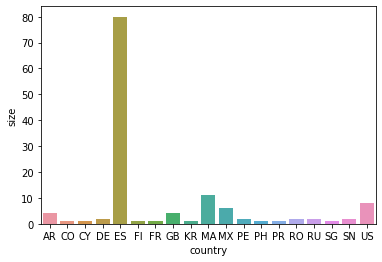

In [320]:
ax = sns.barplot(x="country", y="size", data = channels_per_country)

## Categories of most watched videos in Spain

In [329]:
category_data = get_categories()
category_data = pd.DataFrame(category_data)
category_data

,category,category_id
0,Film & Animation,1
1,Autos & Vehicles,2
2,Music,10
3,Pets & Animals,15
4,Sports,17
5,Short Movies,18
6,Travel & Events,19
7,Gaming,20
8,Videoblogging,21
9,People & Blogs,22


In [330]:
videos_per_category = video_data.groupby("category_id", as_index=False).size()
videos_per_category = pd.merge(videos_per_category, category_data, on= "category_id", how= "inner")

videos_per_category.sort_values("size", ascending=False)

,category_id,size,category
9,24,46,Entertainment
1,10,30,Music
6,20,25,Gaming
7,22,17,People & Blogs
3,17,9,Sports
8,23,8,Comedy
10,25,7,News & Politics
11,26,5,Howto & Style
5,2,4,Autos & Vehicles
0,1,3,Film & Animation


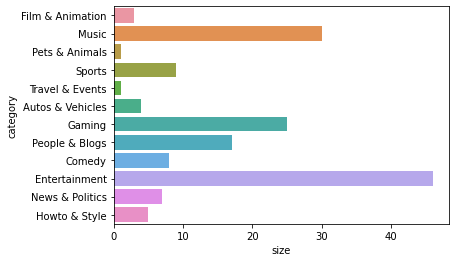

In [332]:
ax2 = sns.barplot(x="size", y="category", data = videos_per_category)